# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [7]:
# import libraries here; 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [8]:
# # load in the data
# azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
# customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [9]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

Loading the data from a pickle as it is taking long time load in the above cell.

In [10]:
azdias = pickle.load(open("azdias.pickle", "rb"))

In [11]:
customers = pickle.load(open("customers.pickle", "rb"))

In [12]:
azdias.head(20)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
6,910248,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2
7,910261,-1,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1
8,645145,-1,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3
9,645153,-1,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3


In [13]:
azdias.shape

(891221, 366)

In [14]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [15]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [16]:
customers.head

<bound method NDFrame.head of            LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0         9626         2         1.0      10.0          NaN          NaN   
1         9628        -1         9.0      11.0          NaN          NaN   
2       143872        -1         1.0       6.0          NaN          NaN   
3       143873         1         1.0       8.0          NaN          NaN   
4       143874        -1         1.0      20.0          NaN          NaN   
5       143888         1         1.0      11.0          NaN          NaN   
6       143904         2         1.0      10.0          NaN          NaN   
7       143910         1         1.0      10.0          NaN          NaN   
8       102160         2         3.0       5.0          NaN          NaN   
9       102173         1         1.0      20.0          NaN          NaN   
10      102184        -1         7.0      14.0          NaN          NaN   
11      102185         1         1.0      10.0          Na

In [17]:
customers.shape

(191652, 369)

In [18]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


## Preprocessing

in this section, missing data will be assessed, some columns' values will be handeled and recoded and a cleaning function will be created to handle the cleaning process for other dataframes. Finally, imputation and scaling will be applied to get the final checked dataframes.

### Assess Missing Data

In [19]:
feat_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
feat_info.head(15)

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,NaN,1,< 30 years
7,NaN,NaN,NaN,2,30 - 45 years
8,NaN,NaN,NaN,3,46 - 60 years
9,NaN,NaN,NaN,4,> 60 years


NaN in the Attribute column will be filled by same value for each attribute. Also, are we are interested into missing data, only rows which contain "unknown" or "no " in the Meaning column, will be retained.

In [20]:
feat_info['Attribute'] = feat_info['Attribute'].fillna(method='ffill')
feat_info = feat_info[(feat_info['Meaning'].str.contains("unknown") | feat_info['Meaning'].str.contains("no "))]
feat_info

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,AGER_TYP,NaN,0,no classification possible
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,NaN,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,NaN,ANREDE_KZ,gender,"-1, 0",unknown
40,NaN,BALLRAUM,distance to next urban centre,-1,unknown
48,NaN,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
49,NaN,BIP_FLAG,NaN,0,no company in the building
51,NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
105,NaN,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown


In [21]:
feat_info.drop('Unnamed: 0',axis=1, inplace=True)
feat_info.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown


In [22]:
feat_info['Value'].value_counts()

-1       138
-1, 9     75
0         58
-1, 0     16
10        12
1          2
-1         1
Name: Value, dtype: int64

In [23]:
missing_values = feat_info.query('Value == "-1, 0"') 

In [24]:
missing_values.Attribute

5        ALTERSKATEGORIE_GROB
33                  ANREDE_KZ
697               GEBAEUDETYP
724             GEOSCORE_KLS7
734         HAUSHALTSSTRUKTUR
749        HH_EINKOMMEN_SCORE
822              KBA05_BAUMAX
864                 KBA05_GBZ
1880                      KKK
1993         NATIONALITAET_KZ
2054    PRAEGENDE_JUGENDJAHRE
2070                 REGIOTYP
2210                 TITEL_KZ
2219           WOHNDAUER_2008
2238       WACHSTUMSGEBIET_NB
2244           W_KEIT_KIND_HH
Name: Attribute, dtype: object

For each attribute, a list of missing values codes will be shown. other columns are not reuqired.

In [25]:
list_ = []
for Attr in feat_info['Attribute'].unique():
    loc_ = feat_info.loc[feat_info['Attribute'] == Attr, 'Value'].astype(str).str.cat(sep=',')
    loc_ = loc_.split(',')
    list_.append(loc_)

missing = pd.concat([pd.Series(feat_info['Attribute'].unique()), pd.Series(list_)], axis=1)
missing.columns = ['attribute', 'missing_']


In [26]:
missing

,attribute,missing_
0,AGER_TYP,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1, 0]"
4,BALLRAUM,[-1]
5,BIP_FLAG,"[-1, 0]"
6,CAMEO_DEUG_2015,[-1]
7,CAMEO_DEUINTL_2015,[-1]
8,CJT_GESAMTTYP,[0]
9,D19_BANKEN_ANZ_12,[0]


In [27]:
print(missing.attribute[0])

AGER_TYP


In [28]:
len(missing)

292

In [29]:
missing.attribute.nunique()

292

In [30]:
feat_info.iloc[0]

Attribute                AGER_TYP
Description    best-ager typology
Value                          -1
Meaning                   unknown
Name: 0, dtype: object

In [31]:
azdias.loc[:, 'AGER_TYP'][0]

-1

Now as we have the missing codes for each attribute, a loop through azdias dataframe will be made to replace the misisng values codes with NaN

In [40]:
for col in missing['attribute']:
    if col in azdias.columns:
        azdias.loc[azdias.loc[:, col].isin(missing.loc[missing['attribute'] == col, 'missing_'].iloc[0]), col] = np.NaN
    else:
        pass


After noticing that in order to run the above loop, it is consuming a lot of time in this workspace. to overcome this, I ran this loop locally. the final result is stored in azdias_.pkl. Due to the storage capacity in this workspace, I had to remove the first pickle and obtain the updated one.

In [41]:
azdias.head(20)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0
5,910244,3.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4.0,2.0,1.0
6,910248,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4.0,2.0,2.0
7,910261,NaN,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1.0,1.0,1.0
8,645145,NaN,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6.0,1.0,3.0
9,645153,NaN,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4.0,2.0,3.0


In [42]:
azdias.shape

(891221, 366)

In [43]:
azdias.GEBAEUDETYP.unique()

array([nan,  8.,  1.,  3.,  2.,  6.,  4.,  5.])

In [44]:
azdias.GEBAEUDETYP.value_counts()

1.0    460465
3.0    178668
8.0    152476
2.0      4935
4.0       900
6.0       628
5.0         1
Name: GEBAEUDETYP, dtype: int64

In [45]:
azdias.AGER_TYP.unique()

array([nan,  2.,  3.,  1.])

In [46]:
azdias.AGER_TYP.value_counts()

2.0    98472
1.0    79802
3.0    27104
Name: AGER_TYP, dtype: int64

### Assess Missing Data in Each Column

After the replacement of missing codes, nulls will be assessed in columns of the dataframe.

In [47]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
dict_ = {}
for column in azdias.columns:
    nan_values = azdias[column].isna().sum()
    dict_[column] = nan_values
print(dict_)

{'LNR': 0, 'AGER_TYP': 685843, 'AKT_DAT_KL': 73499, 'ALTER_HH': 310267, 'ALTER_KIND1': 810163, 'ALTER_KIND2': 861722, 'ALTER_KIND3': 885051, 'ALTER_KIND4': 890016, 'ALTERSKATEGORIE_FEIN': 262947, 'ANZ_HAUSHALTE_AKTIV': 93148, 'ANZ_HH_TITEL': 97008, 'ANZ_KINDER': 73499, 'ANZ_PERSONEN': 73499, 'ANZ_STATISTISCHE_HAUSHALTE': 93148, 'ANZ_TITEL': 73499, 'ARBEIT': 97216, 'BALLRAUM': 93740, 'CAMEO_DEU_2015': 98979, 'CAMEO_DEUG_2015': 98979, 'CAMEO_INTL_2015': 98979, 'CJT_GESAMTTYP': 4854, 'CJT_KATALOGNUTZER': 4854, 'CJT_TYP_1': 4854, 'CJT_TYP_2': 4854, 'CJT_TYP_3': 4854, 'CJT_TYP_4': 4854, 'CJT_TYP_5': 4854, 'CJT_TYP_6': 4854, 'D19_BANKEN_ANZ_12': 831734, 'D19_BANKEN_ANZ_24': 794100, 'D19_BANKEN_DATUM': 678331, 'D19_BANKEN_DIREKT': 0, 'D19_BANKEN_GROSS': 0, 'D19_BANKEN_LOKAL': 0, 'D19_BANKEN_OFFLINE_DATUM': 871535, 'D19_BANKEN_ONLINE_DATUM': 726982, 'D19_BANKEN_ONLINE_QUOTE_12': 845987, 'D19_BANKEN_REST': 0, 'D19_BEKLEIDUNG_GEH': 0, 'D19_BEKLEIDUNG_REST': 0, 'D19_BILDUNG': 0, 'D19_BIO_OEKO': 0

A visual of the nulls in azdias dataframe columns.

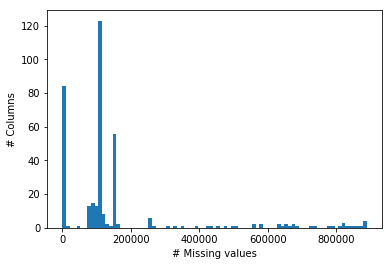

In [48]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(dict_.values(), bins=85)
plt.ylabel('# Columns')
plt.xlabel('# Missing values')
plt.show()

As we can see from the visual, we have columns with huge number of nulls. a cap of 200000 nulls is chosen and columns that have more, will be dropped.

In [49]:
# Remove the outlier columns from the dataset.
dict_200000 = {}
removed_columns = {}
cols = []
for key, value in dict_.items():
    if value < 200000:
        dict_200000[key] = value
    else:
        removed_columns[key] = value
        cols.append(key)
print(dict_200000)
print('------------------')
print(removed_columns)

{'LNR': 0, 'AKT_DAT_KL': 73499, 'ANZ_HAUSHALTE_AKTIV': 93148, 'ANZ_HH_TITEL': 97008, 'ANZ_KINDER': 73499, 'ANZ_PERSONEN': 73499, 'ANZ_STATISTISCHE_HAUSHALTE': 93148, 'ANZ_TITEL': 73499, 'ARBEIT': 97216, 'BALLRAUM': 93740, 'CAMEO_DEU_2015': 98979, 'CAMEO_DEUG_2015': 98979, 'CAMEO_INTL_2015': 98979, 'CJT_GESAMTTYP': 4854, 'CJT_KATALOGNUTZER': 4854, 'CJT_TYP_1': 4854, 'CJT_TYP_2': 4854, 'CJT_TYP_3': 4854, 'CJT_TYP_4': 4854, 'CJT_TYP_5': 4854, 'CJT_TYP_6': 4854, 'D19_BANKEN_DIREKT': 0, 'D19_BANKEN_GROSS': 0, 'D19_BANKEN_LOKAL': 0, 'D19_BANKEN_REST': 0, 'D19_BEKLEIDUNG_GEH': 0, 'D19_BEKLEIDUNG_REST': 0, 'D19_BILDUNG': 0, 'D19_BIO_OEKO': 0, 'D19_BUCH_CD': 0, 'D19_DIGIT_SERV': 0, 'D19_DROGERIEARTIKEL': 0, 'D19_ENERGIE': 0, 'D19_FREIZEIT': 0, 'D19_GARTEN': 0, 'D19_HANDWERK': 0, 'D19_HAUS_DEKO': 0, 'D19_KINDERARTIKEL': 0, 'D19_KONSUMTYP_MAX': 0, 'D19_KOSMETIK': 0, 'D19_LEBENSMITTEL': 0, 'D19_NAHRUNGSERGAENZUNG': 0, 'D19_RATGEBER': 0, 'D19_REISEN': 0, 'D19_SAMMELARTIKEL': 0, 'D19_SCHUHE': 0, 'D1

In [50]:
cols

['AGER_TYP',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ALTERSKATEGORIE_FEIN',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_SOZIALES',
 'D19_TELKO_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_TELKO_DATUM',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_TELKO_ONLINE_DATUM',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSAND_DATUM',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_VERSI_ANZ_12',
 'D19_VERSI_ANZ_24',
 'D19_VERSI_ONLINE_QUOTE_12',
 'EXTSEL992',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_BAUMAX',
 'KBA05_MAXVORB',
 'KK_KUNDE

In [51]:
len(cols)

47

47 columns to be dropped from the dataframe as they have many nulls.

In [52]:
azdias.drop(cols, axis=1, inplace = True)

In [53]:
dict_ = {}
for column in azdias.columns:
    nan_values = azdias[column].isna().sum()
    dict_[column] = nan_values
print(dict_)

{'LNR': 0, 'AKT_DAT_KL': 73499, 'ANZ_HAUSHALTE_AKTIV': 93148, 'ANZ_HH_TITEL': 97008, 'ANZ_KINDER': 73499, 'ANZ_PERSONEN': 73499, 'ANZ_STATISTISCHE_HAUSHALTE': 93148, 'ANZ_TITEL': 73499, 'ARBEIT': 97216, 'BALLRAUM': 93740, 'CAMEO_DEU_2015': 98979, 'CAMEO_DEUG_2015': 98979, 'CAMEO_INTL_2015': 98979, 'CJT_GESAMTTYP': 4854, 'CJT_KATALOGNUTZER': 4854, 'CJT_TYP_1': 4854, 'CJT_TYP_2': 4854, 'CJT_TYP_3': 4854, 'CJT_TYP_4': 4854, 'CJT_TYP_5': 4854, 'CJT_TYP_6': 4854, 'D19_BANKEN_DIREKT': 0, 'D19_BANKEN_GROSS': 0, 'D19_BANKEN_LOKAL': 0, 'D19_BANKEN_REST': 0, 'D19_BEKLEIDUNG_GEH': 0, 'D19_BEKLEIDUNG_REST': 0, 'D19_BILDUNG': 0, 'D19_BIO_OEKO': 0, 'D19_BUCH_CD': 0, 'D19_DIGIT_SERV': 0, 'D19_DROGERIEARTIKEL': 0, 'D19_ENERGIE': 0, 'D19_FREIZEIT': 0, 'D19_GARTEN': 0, 'D19_HANDWERK': 0, 'D19_HAUS_DEKO': 0, 'D19_KINDERARTIKEL': 0, 'D19_KONSUMTYP_MAX': 0, 'D19_KOSMETIK': 0, 'D19_LEBENSMITTEL': 0, 'D19_NAHRUNGSERGAENZUNG': 0, 'D19_RATGEBER': 0, 'D19_REISEN': 0, 'D19_SAMMELARTIKEL': 0, 'D19_SCHUHE': 0, 'D1

A visual for the columns that have less than 200000 nulls

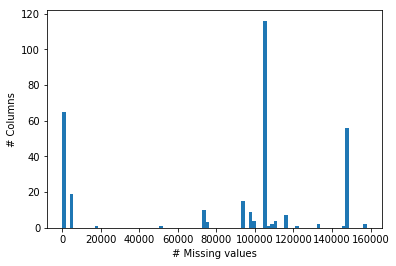

In [54]:
plt.hist(dict_.values(), bins=85)
plt.ylabel('# Columns')
plt.xlabel('# Missing values')
plt.show()

new azdias shape

In [55]:
azdias.shape

(891221, 319)

### Assess Missing Data in Each Row

Now after analysing nulls in each column, same process will be performed on row level.

In [56]:
row_nulls = azdias.isnull().sum(axis=1)

In [57]:
row_nulls.head(20)

0     233
1       0
2       0
3       4
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11    234
12     58
13     61
14    234
15    123
16      2
17    234
18      3
19      0
dtype: int64

A visual of null in row level

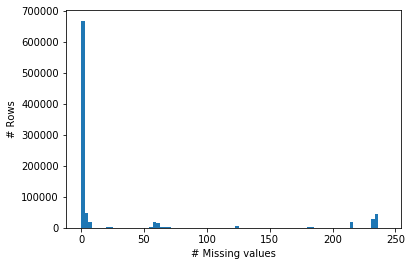

In [58]:
# How much data is missing in each row of the dataset?
dict_i = {}
for i in range(0, len(azdias)):
    row_nan = azdias.iloc[i].isna().sum()
    dict_i[i] = row_nan
plt.hist(dict_i.values(), bins=85)
plt.ylabel('# Rows')
plt.xlabel('# Missing values')
plt.show()


In [89]:
row_nulls.head(20)

0     233
1       0
2       0
3       4
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11    234
12     58
13     61
14    234
15    123
16      2
17    234
18      3
19      0
dtype: int64

A cap of 15 nulls per row in determined based on the visualization.

In [90]:
azdias.drop(azdias.index[row_nulls > 15], axis=0, inplace = True)

In [91]:
azdias.shape

(732895, 319)

### Select and Re-Encode Features

Here as we don't have columns structure as in previous project, same results from previous work for categorical columns, will be used.

In [92]:
cat_cols = ['ANREDE_KZ',
'CJT_GESAMTTYP',
'FINANZTYP',
'GFK_URLAUBERTYP',
'GREEN_AVANTGARDE',
'LP_FAMILIE_FEIN',
'LP_FAMILIE_GROB',
'LP_STATUS_FEIN',
'LP_STATUS_GROB',
'NATIONALITAET_KZ',
'SHOPPER_TYP',
'SOHO_KZ',
'VERS_TYP',
'ZABEOTYP',
'GEBAEUDETYP',
'OST_WEST_KZ',
'CAMEO_DEUG_2015',
'CAMEO_DEU_2015']

values count for each of the categorical columns.

In [93]:
for col in cat_cols:
    if col in azdias.columns:
        print(azdias[col].value_counts())

2.0    382123
1.0    350772
Name: ANREDE_KZ, dtype: int64
4.0    182289
3.0    135152
2.0    133758
5.0    104846
6.0     92100
1.0     84750
Name: CJT_GESAMTTYP, dtype: int64
6.0    277585
1.0    182494
5.0     97323
2.0     93614
4.0     52220
3.0     29659
Name: FINANZTYP, dtype: int64
12.0    118740
10.0     96582
8.0      77124
11.0     70649
5.0      67707
4.0      56673
3.0      51880
9.0      51654
1.0      47846
7.0      36605
2.0      32925
6.0      24510
Name: GFK_URLAUBERTYP, dtype: int64
0    569272
1    163623
Name: GREEN_AVANTGARDE, dtype: int64
1.0     371649
10.0    121768
2.0      91334
11.0     46211
0.0      24369
8.0      19575
7.0      16310
4.0      10485
5.0      10325
9.0       9797
6.0       6954
3.0       4118
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    371649
5.0    177776
2.0     91334
4.0     42839
3.0     24928
0.0     24369
Name: LP_FAMILIE_GROB, dtype: int64
1.0     193116
9.0     119084
2.0     106519
10.0    104698
4.0      70563
3.0      65286
6.0    

Now, as per previous cell, there are binary and non binary categorical columns in the dataframe. A split is required based on catogries for those columns.

In [94]:
binary = []
multi = []
for col in cat_cols:
    if col in azdias.columns:
        if len(azdias[col].unique()) == 2:
            binary.append(col)
        elif len(azdias[col].unique()) > 2:
            multi.append(col)
    else:
        pass
print(binary)
print('-----------')
print(multi)

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']
-----------
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


### Re-encoding

In [95]:
# Re-encode categorical variable(s) to be kept in the analysis.
for col in binary:
    print(col,': ', azdias[col].unique())

ANREDE_KZ :  [2. 1.]
GREEN_AVANTGARDE :  [0 1]
SOHO_KZ :  [1. 0.]
OST_WEST_KZ :  ['W' 'O']


In [96]:
azdias_updated = azdias.replace({'OST_WEST_KZ':{'W':0, 'O':1}})

In [97]:
azdias_updated.CAMEO_DEUG_2015.unique()

array([8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 7.0, 5.0, 3.0, nan, '3', '7', '2',
       '4', '9', '6', '8', '5', '1', 'X'], dtype=object)

In [98]:
azdias_updated = azdias_updated[azdias_updated.CAMEO_DEUG_2015 != 'X']

In [99]:
azdias_updated.CAMEO_DEUG_2015.unique()

array([8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 7.0, 5.0, 3.0, nan, '3', '7', '2',
       '4', '9', '6', '8', '5', '1'], dtype=object)

In [100]:
for col in binary:
    print(col,': ', azdias_updated[col].unique())

ANREDE_KZ :  [2. 1.]
GREEN_AVANTGARDE :  [0 1]
SOHO_KZ :  [1. 0.]
OST_WEST_KZ :  [0 1]


In [101]:
azdias_updated.CAMEO_DEU_2015.unique()

array(['8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '7A',
       '5D', '9E', '5C', '9B', '1B', '8B', '3D', nan, '4E', '4B', '3C',
       '5A', '7B', '9A', '6E', '6D', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C'], dtype=object)

As there is no knowledge on reencoding the values of this column, it will be dropped.

In [102]:
azdias_updated.drop('CAMEO_DEU_2015', axis=1, inplace = True)

In [103]:
azdias_updated.shape

(732613, 318)

A final check before creating the cleaning function, is to check for compatible datatypes. a float data type will be decided for the columns.

In [104]:
cnt = 0
for col in azdias_updated.columns:
        if azdias_updated[col].dtype == np.int64:
            cnt+=1
            azdias_updated[col] = azdias_updated[col].astype(np.float64)
print(cnt)

42


### Create a Cleaning Function

In [5]:
def clean_data(df, missing):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for col in missing['attribute']:
        if col in df.columns:
            df.loc[df.loc[:, col].isin(missing.loc[missing['attribute'] == col, 'missing_'].iloc[0]), col] = np.NaN
        else:
            pass
    
    # columns to be dropped (amount of nulls)
    cols = ['AGER_TYP',
            'ALTER_HH',
            'ALTER_KIND1',
            'ALTER_KIND2',
            'ALTER_KIND3',
            'ALTER_KIND4',
            'ALTERSKATEGORIE_FEIN',
            'D19_BANKEN_ANZ_12',
            'D19_BANKEN_ANZ_24',
            'D19_BANKEN_DATUM',
            'D19_BANKEN_OFFLINE_DATUM',
            'D19_BANKEN_ONLINE_DATUM',
            'D19_BANKEN_ONLINE_QUOTE_12',
            'D19_GESAMT_ANZ_12',
            'D19_GESAMT_ANZ_24',
            'D19_GESAMT_DATUM',
            'D19_GESAMT_OFFLINE_DATUM',
            'D19_GESAMT_ONLINE_DATUM',
            'D19_GESAMT_ONLINE_QUOTE_12',
            'D19_KONSUMTYP',
            'D19_LETZTER_KAUF_BRANCHE',
            'D19_LOTTO',
            'D19_SOZIALES',
            'D19_TELKO_ANZ_12',
            'D19_TELKO_ANZ_24',
            'D19_TELKO_DATUM',
            'D19_TELKO_OFFLINE_DATUM',
            'D19_TELKO_ONLINE_DATUM',
            'D19_TELKO_ONLINE_QUOTE_12',
            'D19_VERSAND_ANZ_12',
            'D19_VERSAND_ANZ_24',
            'D19_VERSAND_DATUM',
            'D19_VERSAND_OFFLINE_DATUM',
            'D19_VERSAND_ONLINE_DATUM',
            'D19_VERSAND_ONLINE_QUOTE_12',
            'D19_VERSI_ANZ_12',
            'D19_VERSI_ANZ_24',
            'D19_VERSI_ONLINE_QUOTE_12',
            'EXTSEL992',
            'KBA05_ANTG1',
            'KBA05_ANTG2',
            'KBA05_ANTG3',
            'KBA05_ANTG4',
            'KBA05_BAUMAX',
            'KBA05_MAXVORB',
            'KK_KUNDENTYP',
            'TITEL_KZ']
    
    
    df.drop(cols, axis=1, inplace = True)
    
    # rows dropped
    row_nulls = df.isnull().sum(axis=1)
    df.drop(df.index[row_nulls > 15], axis=0, inplace = True)
    
    # dropped for encoding issue
    df.drop('CAMEO_DEU_2015', axis=1, inplace = True)
    
    # dropped 'X' from this column encoding
    df = df[df.CAMEO_DEUG_2015 != 'X']
    
    # encoding
    df = df.replace({'OST_WEST_KZ':{'W':0, 'O':1}})
    
    # check types
    for col in df.columns:
            if df[col].dtype == np.int64:
                df[col] = df[col].astype(np.float64)
    
    # Return the cleaned dataframe.
    
    return df

Apply cleaning function on customers dataftame.

In [114]:
customers.shape

(191652, 369)

In [115]:
customers = clean_data(customers, missing)

In [116]:
customers.shape

(131127, 321)

In [117]:
customers.head(20)

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,3.0,...,2.0,6.0,9.0,7.0,3.0,COSMETIC_AND_FOOD,MULTI_BUYER,0.0,1.0,4.0
2,143872.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,7.0,...,11.0,6.0,9.0,2.0,3.0,COSMETIC_AND_FOOD,MULTI_BUYER,0.0,2.0,4.0
3,143873.0,1.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,7.0,...,2.0,NaN,9.0,7.0,1.0,COSMETIC,MULTI_BUYER,0.0,1.0,4.0
4,143874.0,1.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,3.0,...,4.0,2.0,9.0,3.0,1.0,FOOD,MULTI_BUYER,0.0,1.0,3.0
5,143888.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,7.0,...,1.0,6.0,9.0,1.0,2.0,COSMETIC_AND_FOOD,MULTI_BUYER,0.0,1.0,3.0
6,143904.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,6.0,...,2.0,6.0,9.0,7.0,1.0,COSMETIC_AND_FOOD,MULTI_BUYER,0.0,1.0,4.0
7,143910.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,5.0,...,1.0,6.0,9.0,3.0,3.0,FOOD,SINGLE_BUYER,0.0,1.0,4.0
8,102160.0,3.0,74.0,2.0,0.0,1.0,82.0,0.0,3.0,3.0,...,9.0,6.0,3.0,4.0,3.0,COSMETIC,MULTI_BUYER,0.0,2.0,4.0
9,102173.0,1.0,1.0,0.0,0.0,3.0,1.0,0.0,3.0,2.0,...,4.0,2.0,9.0,5.0,1.0,COSMETIC,MULTI_BUYER,0.0,1.0,3.0
11,102185.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,6.0,...,2.0,6.0,3.0,4.0,1.0,FOOD,SINGLE_BUYER,0.0,1.0,4.0


### Missing values (Impute)

In [120]:
azdias_updated['EINGEFUEGT_AM'].unique()

array(['1992-02-10 00:00:00', '1992-02-12 00:00:00',
       '1997-04-21 00:00:00', ..., '1994-10-24 00:00:00',
       '2000-03-09 00:00:00', '2005-03-19 00:00:00'], dtype=object)

In [121]:
azdias_updated.drop('EINGEFUEGT_AM', axis=1, inplace = True)

In [122]:
customers.drop('EINGEFUEGT_AM', axis=1, inplace = True)

after running below cell, it turns out that there is a column with date values. it is dropped in both azdias and customers in aboce cells.

In [123]:
nan_processed = Imputer(strategy='most_frequent')
azdias_processed = nan_processed.fit_transform(azdias_updated)
azdias_processed = pd.DataFrame(azdias_processed)
azdias_processed.columns = azdias_updated.columns

In [124]:
azdias_processed.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910220.0,9.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
1,910225.0,9.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
2,910226.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,...,0.0,7.0,10.0,11.0,6.0,9.0,7.0,3.0,2.0,4.0
3,910241.0,1.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0
4,910244.0,1.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,6.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4.0,2.0,1.0


Before running below cell, as the 3 columns that exist on customers but not in azdias has not been handled in before steps and due to their data types, the approach is to remove them from customers, retain them externally and apply same steps as for azdias.

In [125]:
customers_other_cols = customers[['ONLINE_PURCHASE','CUSTOMER_GROUP', 'PRODUCT_GROUP']]
customers.drop('ONLINE_PURCHASE', axis=1, inplace = True)
customers.drop('CUSTOMER_GROUP', axis=1, inplace = True)
customers.drop('PRODUCT_GROUP', axis=1, inplace = True)

In [126]:
cust_nan_processed = Imputer(strategy='most_frequent')
custs_processed = cust_nan_processed.fit_transform(customers)
custs_processed = pd.DataFrame(custs_processed)
custs_processed.columns = customers.columns

In [127]:
custs_processed.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,3.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3.0,1.0,4.0
1,143872.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,7.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3.0,2.0,4.0
2,143873.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,7.0,...,2.0,6.0,4.0,2.0,6.0,9.0,7.0,1.0,1.0,4.0
3,143874.0,1.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,3.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1.0,1.0,3.0
4,143888.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,7.0,...,4.0,1.0,2.0,1.0,6.0,9.0,1.0,2.0,1.0,3.0


### Scaling

In [128]:
Scale = StandardScaler()
azdias_SCALE = Scale.fit_transform(azdias_processed)
azdias_SCALE = pd.DataFrame(azdias_SCALE)
azdias_SCALE.columns = azdias_processed.columns

In [129]:
azdias_SCALE.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.057814,1.258961,0.186066,-0.125355,-0.298768,0.226031,0.334489,-0.060518,-0.183474,0.849368,...,1.375768,0.698562,1.065142,1.460763,-0.748673,0.547648,-0.028913,1.140960,0.958145,-1.681282
1,1.057833,1.258961,0.119934,-0.125355,-0.298768,-0.633416,-0.032492,-0.060518,-0.183474,-0.980610,...,-0.355059,1.049440,0.451488,0.027257,-0.748673,0.547648,-1.083639,1.140960,0.958145,0.168553
2,1.057837,-0.936337,-0.475250,-0.125355,-0.298768,-1.492864,-0.399474,-0.060518,-1.187532,-0.065621,...,-2.085886,0.347684,0.758315,1.819140,0.951733,0.547648,1.553176,-0.280504,0.958145,1.093470
3,1.057895,-0.936337,-0.342987,-0.125355,-0.298768,1.944925,-0.326078,-0.060518,0.820584,-0.980610,...,-0.355059,-1.055828,-0.775820,-0.689496,-1.315475,0.547648,-0.556276,0.430228,-1.043684,0.168553
4,1.057907,-0.936337,-0.210724,-0.125355,-0.298768,-0.633416,-0.399474,-0.060518,-1.187532,0.849368,...,-0.355059,1.400317,-0.162166,-0.689496,0.951733,0.547648,1.553176,0.430228,0.958145,-1.681282


In [130]:
Custs_Scale = StandardScaler()
custs_SCALE = Custs_Scale.fit_transform(custs_processed)
custs_SCALE = pd.DataFrame(custs_SCALE)
custs_SCALE.columns = custs_processed.columns

In [131]:
custs_SCALE.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-1.560132,-0.350104,-0.273550,-0.124608,-0.265784,-0.206102,-0.257090,-0.134603,-1.811690,-0.616957,...,0.506871,0.220150,-0.524497,-0.502057,0.866919,0.27539,1.579466,0.464043,-0.698666,0.650488
1,0.864423,-0.350104,-0.273550,-0.124608,-0.265784,-0.920687,-0.257090,-0.134603,0.172047,1.275479,...,1.384048,1.926880,2.953996,3.589474,0.866919,0.27539,-0.838068,0.464043,1.431298,0.650488
2,0.864441,-0.350104,-0.346028,-0.124608,-0.265784,-1.635272,-0.257090,-0.134603,-1.811690,1.275479,...,-0.370305,0.561496,-0.176648,-0.502057,0.866919,0.27539,1.579466,-1.071897,-0.698666,0.650488
3,0.864459,-0.350104,0.161316,-0.124608,-0.265784,1.223067,0.183899,-0.134603,0.172047,-0.616957,...,1.384048,-0.462542,0.171202,0.407172,-1.281102,0.27539,-0.354561,-1.071897,-0.698666,-0.673232
4,0.864712,-0.350104,-0.273550,-0.124608,-0.265784,-0.206102,-0.257090,-0.134603,0.172047,1.275479,...,1.384048,-1.145234,-0.872346,-0.956671,0.866919,0.27539,-1.321575,-0.303927,-0.698666,-0.673232


In [133]:
azdias_SCALE.shape

(732613, 317)

In [134]:
custs_SCALE.shape

(131127, 317)

In [135]:
azdias = azdias_SCALE

In [136]:
customers = custs_SCALE

In [137]:
pickle.dump(azdias, open("azdias_data_checked.pickle", "wb"))

In [138]:
pickle.dump(customers, open("customers_data_checked.pickle", "wb"))

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [21]:
azdias = pickle.load(open("azdias_data_checked.pickle", "rb"))

In [22]:
customers = pickle.load(open("customers_data_checked.pickle", "rb"))

After scaling, a dimensionality reduction technique will be applied to find the vectors of maximal variance in the data.

In [139]:
# Apply PCA to the data.
PCA = PCA()
PCA.fit(azdias)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

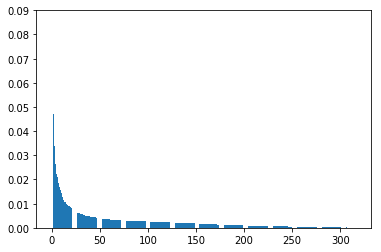

In [140]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(PCA.explained_variance_ratio_)), PCA.explained_variance_ratio_)
plt.show()

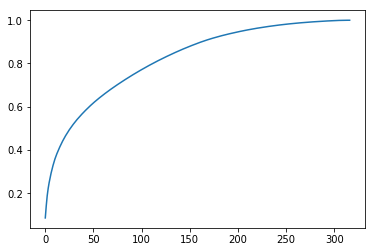

In [141]:
plt.plot(range(len(PCA.explained_variance_ratio_)), np.cumsum(PCA.explained_variance_ratio_))
plt.show()

35 will be the number of transformed features retained for clustering.

In [143]:
# Re-apply PCA to the data while selecting for number of components to retain.
PCA_ = PCA(n_components=35)
azdias_ = PCA_.fit_transform(azdias)

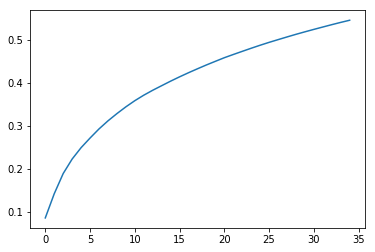

In [144]:
plt.plot(range(len(PCA_.explained_variance_ratio_)), np.cumsum(PCA_.explained_variance_ratio_))
plt.show()

checking the weight of each variable on few components.

In [145]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
def weighted(p, x):
    weighted_df = pd.DataFrame(p.components_, columns=azdias.columns)
    weight_value = weighted_df.iloc[x].sort_values(ascending=False)
    return weight_value

In [146]:
pca0 = weighted(PCA_, 0)
pca1 = weighted(PCA_, 1)
pca2 = weighted(PCA_, 2)

In [147]:
print(pca0)

PLZ8_ANTG3                    0.146120
KBA13_ANTG3                   0.145305
KBA13_ANTG4                   0.141407
KBA13_BAUMAX                  0.141043
PLZ8_ANTG4                    0.140075
PLZ8_BAUMAX                   0.139311
CAMEO_DEUG_2015               0.135925
CAMEO_INTL_2015               0.132104
HH_EINKOMMEN_SCORE            0.131998
EWDICHTE                      0.119438
ORTSGR_KLS9                   0.119298
FINANZ_HAUSBAUER              0.104287
PLZ8_ANTG2                    0.098556
ARBEIT                        0.098173
KBA13_HALTER_30               0.095541
KBA13_HALTER_35               0.089839
ZABEOTYP                      0.085977
RELAT_AB                      0.083842
STRUKTURTYP                   0.083762
ANZ_HAUSHALTE_AKTIV           0.081314
VK_DISTANZ                    0.080558
ANZ_STATISTISCHE_HAUSHALTE    0.080162
KONSUMZELLE                   0.080016
VK_ZG11                       0.077212
KBA13_ANTG2                   0.076498
CJT_TYP_2                

In [148]:
print(pca1)

KBA13_HERST_BMW_BENZ           0.186443
KBA13_SEG_OBEREMITTELKLASSE    0.160482
KBA13_MERCEDES                 0.159748
KBA13_BMW                      0.155266
KBA13_SITZE_4                  0.149539
KBA13_SEG_SPORTWAGEN           0.143197
KBA05_HERST1                   0.130590
KBA13_KMH_211                  0.128578
KBA13_KMH_250                  0.126289
KBA13_KW_121                   0.125519
KBA13_SEG_OBERKLASSE           0.123997
KBA13_CCM_2501                 0.119861
KBA05_KW3                      0.119415
KBA13_CCM_3000                 0.111672
KBA05_MOTOR                    0.111390
KBA13_KRSHERST_BMW_BENZ        0.109383
KBA13_CCM_3001                 0.107071
KBA05_MOD1                     0.106438
KBA05_CCM4                     0.105579
KBA13_HALTER_65                0.100948
EWDICHTE                       0.100710
KBA05_SEG5                     0.096943
STRUKTURTYP                    0.094105
ORTSGR_KLS9                    0.088818
KBA13_CCM_2500                 0.088615


In [149]:
print(pca2)

FINANZ_VORSORGER         0.195265
CJT_TYP_5                0.194492
ALTERSKATEGORIE_GROB     0.190196
CJT_TYP_4                0.186701
CJT_TYP_3                0.181543
CJT_TYP_6                0.180715
KOMBIALTER               0.158752
CJT_KATALOGNUTZER        0.148755
SEMIO_LUST               0.141877
RETOURTYP_BK_S           0.138184
SEMIO_ERL                0.127239
W_KEIT_KIND_HH           0.116553
FINANZ_MINIMALIST        0.112391
FINANZTYP                0.098992
VK_DHT4A                 0.078670
WOHNDAUER_2008           0.063524
KBA05_ALTER4             0.052831
FINANZ_HAUSBAUER         0.051255
SHOPPER_TYP              0.049511
D19_VERSI_DATUM          0.047366
KBA05_MAXAH              0.046070
D19_KONSUMTYP_MAX        0.042329
KBA05_VORB0              0.042175
ARBEIT                   0.036023
RT_SCHNAEPPCHEN          0.033568
KBA13_ANTG3              0.033503
KBA13_HALTER_66          0.032664
EWDICHTE                 0.032268
PLZ8_ANTG3               0.032020
UMFELD_JUNG   

in the first PC:

the strongest positive weights are "Number of 6-10 family houses" (PLZ8_ANTG3) and "Number of 10+ family houses" (KBA13_ANTG3) which naturally represent a logical relationship, while the storngest negitive weights are "Movement patterns" (MOBI_REGIO) and "Number of 1-2 family houses" (PLZ8_ANTG1) where we can understand that movement become less with inreased number of family members in a house and become higher with less family members in a house.

in the second PC:

the strongest positive weights are "share of BMW & Mercedes Benz" (KBA13_HERST_BMW_BENZ) and "share of upper middle class cars and upper class cars" (KBA13_SEG_OBEREMITTELKLASSE) which also represent a logical relationship in sharing upper class cars. while the strongest negitive weigths are (KBA13_SEG_KLEINWAGEN) "share of small and very small cars" and (KBA13_SITZE_5) "number of cars with 5 seats " which in another way shows a negitive relationship between very small cars and having a space of 5 persons in the car.

in the third PC: the strongest positive weights are (FINANZ_VORSORGER) "financial typology: be prepared"and (CJT_TYP_5) "customer journey typology" which represent a logical relationship in terms of Personality typoligies in terms of purchesing habits and a financial linkage and preperation to complement those habits. while the strongest negitive weigths are (CJT_TYP_1) and (PRAEGENDE_JUGENDJAHRE) "dominating movement in the person's youth" which implies differnces in movements and generation a person belong to, has an impact on customer journey typology.

### Clustering

checking how data clusters in the principal components space.

In [150]:
# Over a number of different cluster counts...


# run k-means clustering on the data and...
    
    
# compute the average within-cluster distances.
    
list_ = []
range_ = list(range(1,20))
for i in range_:
    print(i)
    kmean = KMeans(n_clusters = i)
    model = kmean.fit(azdias_)
    result = model.score(azdias_)
    score_ = np.abs(result)
    list_.append(score_)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [151]:
arr = [[model,result,score_,list_]]
arr = np.array(arr)

In [152]:
arr.dump('output_')

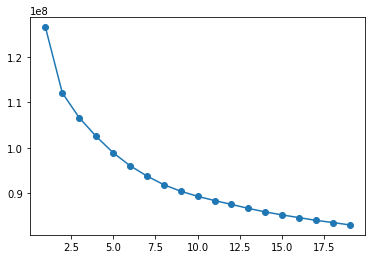

In [154]:
# Investigate the change in within-cluster distance across number of clusters.
range_ = list(range(1,20))
plt.plot(range_, list_, linestyle='-', marker='o')

based on the visualization, 11 clusters has been choosen to segment the population.

In [4]:
model = np.load('output_')[0][0]

In [5]:
result = np.load('output_')[0][1]

In [6]:
score_ = np.load('output_')[0][2]

In [7]:
list_ = np.load('output_')[0][3]

In [155]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmean = KMeans(n_clusters = 11)
model_ = kmean.fit(azdias_)
predict_ = model_.predict(azdias_)

### Apply  to the Customer Data

In [156]:
customers_= PCA_.transform(customers)

cust_pred = model_.predict(customers_)

comparing the two cluster distributions to see where the strongest customer base for the company is.

Text(0.5,1,'azdias')

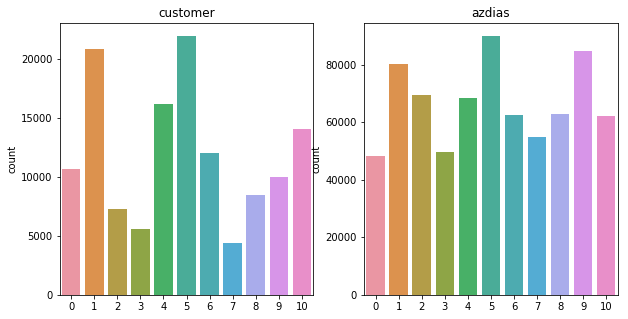

In [158]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
#for i in range (0, len(columns)):
sns.countplot(x=cust_pred, ax=axs[0])
axs[0].set_title('customer')
sns.countplot(x=predict_, ax=axs[1])
axs[1].set_title('azdias')

In [160]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

cust_1 = Scale.inverse_transform(PCA_.inverse_transform(model_.cluster_centers_[1]))

In [161]:
cust_1 = pd.DataFrame(data=cust_1, index=customers.columns)

In [162]:
cust_1

,0
LNR,710933.928368
AKT_DAT_KL,3.848792
ANZ_HAUSHALTE_AKTIV,2.558564
ANZ_HH_TITEL,0.004482
ANZ_KINDER,0.026137
ANZ_PERSONEN,1.380320
ANZ_STATISTISCHE_HAUSHALTE,2.490547
ANZ_TITEL,0.002754
ARBEIT,2.421223
BALLRAUM,5.235395


In [163]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cust_7 = Scale.inverse_transform(PCA_.inverse_transform(model_.cluster_centers_[7]))

In [164]:
cust_7 = pd.DataFrame(data=cust_7, index=customers.columns)


In [165]:
cust_7

,0
LNR,294872.590788
AKT_DAT_KL,4.850184
ANZ_HAUSHALTE_AKTIV,15.970418
ANZ_HH_TITEL,0.080267
ANZ_KINDER,0.078334
ANZ_PERSONEN,1.451935
ANZ_STATISTISCHE_HAUSHALTE,14.738506
ANZ_TITEL,0.005447
ARBEIT,4.371652
BALLRAUM,4.522856


As we can see from the visualizations, segment 1 is overrepresented in customer data compared to azdias data which is considered relativly popular to mail-order company. While segment 7 is considered relativly unpopular to mail-order comapny.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

Applying same steps as before on the mailout_train data

In [3]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train = pickle.load(open("mailout_train.pickle", "rb"))

In [32]:
mailout_train = clean_data(mailout_train, missing)

In [33]:
mailout_train.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763.0,1.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,5.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3.0,0.0,2.0,4.0
1,1771.0,4.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,5.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1.0,0.0,2.0,3.0
2,1776.0,1.0,0.0,NaN,0.0,0.0,1.0,0.0,4.0,1.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3.0,0.0,1.0,4.0
3,1460.0,1.0,4.0,0.0,0.0,2.0,4.0,0.0,4.0,2.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3.0,0.0,2.0,4.0
4,1783.0,1.0,53.0,0.0,0.0,1.0,44.0,0.0,3.0,4.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3.0,0.0,1.0,3.0


In [34]:
mailout_train.shape

(33261, 319)

In [35]:
mailout_train.RESPONSE.value_counts()

0.0    32848
1.0      413
Name: RESPONSE, dtype: int64

In [36]:
y = mailout_train['RESPONSE']
mailout_train.drop('RESPONSE', axis=1, inplace = True)
X = mailout_train

In [37]:
X.shape

(33261, 318)

In [38]:
X.drop('EINGEFUEGT_AM', axis=1, inplace = True)

In [39]:
nan_processed = Imputer(strategy='most_frequent')
X_ = nan_processed.fit_transform(X)
X_ = pd.DataFrame(X_)
X_.columns = X.columns

In [40]:
X_.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763.0,1.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,5.0,...,2.0,5.0,2.0,1.0,6.0,9.0,3.0,3.0,2.0,4.0
1,1771.0,4.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,5.0,...,3.0,1.0,2.0,1.0,4.0,9.0,7.0,1.0,2.0,3.0
2,1776.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,...,1.0,6.0,4.0,2.0,6.0,9.0,2.0,3.0,1.0,4.0
3,1460.0,1.0,4.0,0.0,0.0,2.0,4.0,0.0,4.0,2.0,...,4.0,8.0,11.0,11.0,6.0,9.0,1.0,3.0,2.0,4.0
4,1783.0,1.0,53.0,0.0,0.0,1.0,44.0,0.0,3.0,4.0,...,4.0,2.0,2.0,1.0,6.0,9.0,3.0,3.0,1.0,3.0


In [41]:
Scale = StandardScaler()
X_SCALE = Scale.fit_transform(X_)
X_SCALE = pd.DataFrame(X_SCALE)
X_SCALE.columns = X_.columns

In [42]:
X_SCALE.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-1.650859,-0.283359,0.569224,-0.128298,-0.221683,-0.756730,0.498026,-0.091469,-0.042556,0.334063,...,-0.329695,0.219114,-0.756490,-0.830254,0.736673,0.246682,-0.523206,0.209501,0.854928,0.585230
1,-1.650538,1.551334,-0.371388,-0.128298,-0.221683,-0.024183,-0.364090,-0.091469,-1.009397,0.334063,...,0.547724,-1.045715,-0.756490,-0.830254,-0.411092,0.246682,1.447673,-1.425460,0.854928,-0.651528
2,-1.650338,-0.283359,-0.438574,-0.128298,-0.221683,-1.489277,-0.364090,-0.091469,0.924285,-1.490521,...,-1.207113,0.535321,-0.146230,-0.432594,0.736673,0.246682,-1.015926,0.209501,-1.169690,0.585230
3,-1.663013,-0.283359,-0.169828,-0.128298,-0.221683,-0.024183,-0.148561,-0.091469,0.924285,-1.034375,...,1.425142,1.167736,1.989678,3.146343,0.736673,0.246682,-1.508646,0.209501,0.854928,0.585230
4,-1.650057,-0.283359,3.122314,-0.128298,-0.221683,-0.756730,2.725161,-0.091469,-0.042556,-0.122083,...,1.425142,-0.729508,-0.756490,-0.830254,0.736673,0.246682,-0.523206,0.209501,-1.169690,-0.651528


Logistic Regession has been choosed for the model.

In [43]:
clf = LogisticRegression()
Grid_ = GridSearchCV(clf, param_grid={}, scoring = 'roc_auc')
Grid_ = Grid_.fit(X_SCALE, y)
print(Grid_.best_score_)
print(Grid_.best_estimator_)

0.655871968898
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [50]:
param_grid = {'C': [0.1, 1.0],
             'random_state': [1]}

In [51]:
clf = LogisticRegression()
Grid_ = GridSearchCV(clf, param_grid=param_grid, scoring = 'roc_auc')
Grid_ = Grid_.fit(X_SCALE, y)
print(Grid_.best_score_)
print(Grid_.best_estimator_)

0.657296891401
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

Applying same steps as before on the mailout_test data

In [125]:
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test = pickle.load(open("mailout_test.pickle", "rb"))

In [126]:
mailout_test = clean_data(mailout_test, missing)

In [127]:
mailout_test.shape

(42826, 318)

A copy of LNR column

In [128]:
LNR_ = mailout_test['LNR']

In [129]:
LNR_ = LNR_.astype(np.int32)

In [130]:
mailout_test.drop('EINGEFUEGT_AM', axis=1, inplace = True)

In [131]:
nan_processed = Imputer(strategy='most_frequent')
mailout_test_ = nan_processed.fit_transform(mailout_test)
mailout_test_ = pd.DataFrame(mailout_test_)
mailout_test_.columns = mailout_test.columns

In [132]:
mailout_test_.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754.0,1.0,2.0,0.0,0.0,2.0,2.0,0.0,3.0,6.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3.0,1.0,4.0
1,1770.0,1.0,20.0,0.0,0.0,1.0,21.0,0.0,4.0,7.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3.0,1.0,4.0
2,1465.0,9.0,2.0,0.0,0.0,4.0,2.0,0.0,4.0,1.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3.0,2.0,4.0
3,1470.0,7.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,...,2.0,6.0,6.0,3.0,6.0,9.0,2.0,3.0,2.0,4.0
4,1478.0,1.0,1.0,0.0,0.0,4.0,1.0,0.0,3.0,6.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4.0,2.0,4.0


In [133]:
Scale = StandardScaler()
mailout_test_SCALE = Scale.fit_transform(mailout_test_)
mailout_test_SCALE = pd.DataFrame(mailout_test_SCALE)
mailout_test_SCALE.columns = mailout_test_.columns

In [134]:
mailout_test_SCALE.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-1.665726,-0.271487,-0.273357,-0.120882,-0.206947,0.108587,-0.262320,-0.088603,-0.211056,0.674456,...,1.627690,0.396152,0.642991,0.107472,0.642332,0.244738,-0.475907,0.178386,-1.213227,0.728676
1,-1.665080,-0.271487,1.046941,-0.120882,-0.206947,-0.660829,1.210907,-0.088603,0.774516,1.153688,...,-1.244989,0.396152,-0.584108,-0.719072,0.642332,0.244738,0.578202,0.178386,-1.213227,0.728676
2,-1.677400,4.721989,-0.273357,-0.120882,-0.206947,1.647420,-0.262320,-0.088603,0.774516,-1.721703,...,0.670131,1.668198,0.642991,0.107472,-1.754976,0.244738,0.051147,0.178386,0.824248,0.728676
3,-1.677198,3.473620,-0.346707,-0.120882,-0.206947,-1.430246,-0.339859,-0.088603,0.774516,-1.721703,...,-0.287429,0.714163,0.642991,0.107472,0.642332,0.244738,-1.002962,0.178386,0.824248,0.728676
4,-1.676875,-0.271487,-0.346707,-0.120882,-0.206947,1.647420,-0.339859,-0.088603,-0.211056,0.674456,...,-1.244989,-0.557883,0.029441,0.107472,-1.155649,0.244738,1.632311,1.070756,0.824248,0.728676


using our model to predict the responses

In [135]:
predict_ = Grid_.predict_proba(mailout_test_SCALE)

In [136]:
predict_

array([[0.96755999, 0.03244001],
       [0.98100063, 0.01899937],
       [0.99720212, 0.00279788],
       ...,
       [0.99378627, 0.00621373],
       [0.9711826 , 0.0288174 ],
       [0.99391193, 0.00608807]])

In [137]:
final_ = pd.DataFrame({'LNR':LNR_, 'RESPONSE':predict_[:, 1]})

In [138]:
final_.to_csv('final.csv', index = False)

In [139]:
final_.head().sort_values('RESPONSE',ascending=False )

,LNR,RESPONSE
0,1754,0.032440
1,1770,0.018999
4,1478,0.003908
3,1470,0.003569
2,1465,0.002798


Improvements: In order to get better results as future work, reevaluate the dropped columns and rows and how to make use of them or change the caps or imputation strategy. Another factor is to use more models and add model optimzations to try improving the result.